## Introduction
Shopping can be hard for everyone: from inconsistent sizing to overwhelming options, finding the perfect fit is often a difficult task. The same size might mean different things across different brands-a size 8 dress might fit perfectly at one retailer and run two sizes small at another. This costs the fashion industry billions annually through returns and lost sales, and frustrates consumers who can't find clothes that fit well without trying on multiple sizes. The problem is heightened when shopping online, as customers can't try on items before they buy or rent them, leading to a high return rate for fashion purchased online and low customer satisfaction. For rental services like Rent the Runway, which lend items for a limited time to be worn on special occasions, getting the fit right on the first try is especially critical.

In this work, we use the Rent the Runway dataset, comprising more than 192,000 customer reviews, to predict whether an item will fit a user as 'small', 'fit', or 'large' based on body measurements, demographics, and garment attributes. Our objectives are two-fold: first, to determine which features of the users and items are most informative for predicting fit across different categories of clothing and second, to establish whether classical machine learning approaches, such as Random Forest and Logistic Regression, can achieve competitive performance on this task using only structured data and without review text and collaborative filtering. We cast this as a three-class classification problem and assess our models using stratified k-fold cross-validation with user-level splits. By identifying key predictors of fit and establishing robust baseline performance, this work contributes to the larger mission of improved size recommendation systems to reduce returns, improve customer satisfaction, and make online shopping more accessible for women of all body types.

In [1]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0) if torch.cuda.is_available() else None

(True, 'NVIDIA RTX A5000')

In [2]:
# Imports
import gzip
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, mean_absolute_error,
                             accuracy_score, precision_score, precision_recall_fscore_support, recall_score,
                             make_scorer, f1_score, root_mean_squared_error)
from scipy.stats import ttest_ind

In [3]:
# Helper function to open data
def open_file_df(path):
    rows = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            rows.append(json.loads(line))

    df = pd.DataFrame(rows)
    return df

In [4]:
# Load in data
df_rent = open_file_df('renttherunway_final_data.json.gz')
#df_mod = open_file_df('modcloth_final_data.json.gz')

In [5]:
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


## Preprocessing

We start with cleaning the RentTheRunway data.

In [6]:
# Deal with string cols
str_cols = ["fit", "bust size", "rented for", "review_text","body type", "review_summary", "category"]
df_rent[str_cols] = df_rent[str_cols].astype("string")

# Deal with int cols
int_cols = ["user_id", "item_id", "rating", "size", "age"]
for col in int_cols:
    df_rent[col] = pd.to_numeric(df_rent[col], errors='coerce').astype("Int64")

In [7]:
# Weight col
df_rent["weight"] = (df_rent["weight"].astype("string").str.extract(r"(\d+)", expand=False) .astype("float"))

# Height col helper function
def parse_height(x):
    if not isinstance(x, str):
        return np.nan

    # extract feet and inches
    m = re.match(r"^\s*(\d+)'\s*(\d+)?", x)
    if not m:
        return np.nan

    feet = float(m.group(1))
    inches = float(m.group(2)) if m.group(2) else 0.0

    return feet * 12 + inches

# Apply height cleaning function
df_rent["height_inches"] = df_rent["height"].apply(parse_height)

In [8]:
# Convert bust size to number(band) and letter(cup)

# Band col
df_rent["bust_band"] = (df_rent["bust size"].str.extract(r"(\d+)", expand=False).astype("float"))

# Cup col
df_rent["bust_cup"] = (df_rent["bust size"].str.extract(r"([a-zA-Z]+)", expand=False).str.upper())

# Date col - use pd datetime
df_rent["review_date"] = pd.to_datetime(df_rent["review_date"], errors="coerce")

In [9]:
# Convert "cocktail" category in rented for column into "party"
df_rent['rented_for'] = df_rent['rented for'].replace('party: cocktail', 'party')

In [10]:
# Drop rows with age > 100
df_rent = df_rent[df_rent.age <= 100]

# Drop rows with age == 0
#df_rent = df_rent[df_rent.age != 0]
# age 0 means under 1 year old => baby clothes, true because theres 1, 2, ... too

# Drop rows with size > 40
#df_rent = df_rent[df_rent['size'] <= 40]
# no reason

In [11]:
# Convert fit into numerical labels
fit_dict={'fit':0, 'small':-1, 'large':1}
df_rent.fit = df_rent.fit.apply(lambda x: fit_dict[x])

In [12]:
# Reduce categories from 68 to 10

# 10 categories definition
category_groups = {
    "dress": [
        "dress", "gown", "ballgown", "sheath", "shirtdress",
        "shift", "frock", "maxi", "mini", "midi"
    ],
    "jumpsuit/romper": [
        "jumpsuit", "romper", "overalls", "combo"
    ],
    "top": [
        "top", "blouse", "shirt", "tank", "tee", "t-shirt",
        "cami", "henley", "buttondown", "turtleneck", "blouson"
    ],
    "knitwear": [
        "sweater", "pullover", "knit", "cardigan", "crewneck",
        "hoodie", "sweatshirt", "sweatershirt"
    ],
    "pants": [
        "pants", "pant", "trouser", "trousers", "leggings",
        "legging", "jogger", "jeans", "culottes", "culotte",
        "sweatpants", "tight"
    ],
    "skirt": [
        "skirt", "skirts", "skort"
    ],
    "outerwear": [
        "jacket", "coat", "peacoat", "trench", "bomber",
        "blazer", "vest", "duster", "cape", "parka",
        "overcoat", "down"
    ],
    "ethnic/flowy": [
        "kaftan", "caftan", "kimono", "tunic", "poncho"
    ],
    "suit": ["suit"]
}

# make the map
category_map = {}
for new_cat, old_list in category_groups.items():
    for old_cat in old_list:
        category_map[old_cat] = new_cat

# apply mapping and set 'other' for unmapped
df_rent["category_clean"] = df_rent["category"].map(category_map).fillna("misc")


In [13]:
#do this during pre processing for the model

cup_order = ["AA", "A", "B", "C", "D", "DD", "DDD", "E", "F", "G"]
#df_rent["bust_cup"] = pd.Categorical(df_rent["bust_cup"],categories=cup_order,ordered=True)

In [14]:
df_rent['fit_label'] = df_rent['fit'].map({-1: "small", 0: "fit", 1: "large"})
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,height_inches,bust_band,bust_cup,rented_for,category_clean,fit_label
0,0,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,"5' 8""",14,28,2016-04-20,68.0,34.0,D,vacation,jumpsuit/romper,fit
1,0,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,"5' 6""",12,36,2013-06-18,66.0,34.0,B,other,dress,fit
3,0,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,"5' 5""",8,34,2014-02-12,65.0,34.0,C,formal affair,dress,fit
4,0,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,"5' 9""",12,27,2016-09-26,69.0,34.0,B,wedding,dress,fit
5,0,734848,32b,364092,138.0,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,"5' 8""",8,45,2016-04-30,68.0,32.0,B,date,dress,fit


## EDA - RentTheRunway

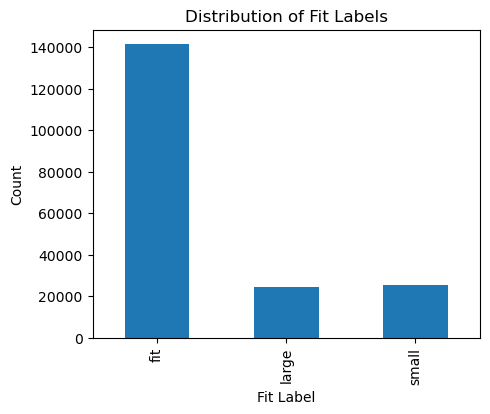

In [15]:
# Distribution of fit labels
plt.figure(figsize=(5,4))
df_rent['fit_label'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Fit Labels")
plt.xlabel("Fit Label")
plt.ylabel("Count")
plt.show()

The bar chart above shows a class imbalance with the majority of items fitting correctly, while "small" and "large" fit issues each represent only a small number of cases, which will require careful handling during model training to avoid biased predictions toward the majority "fit" class.

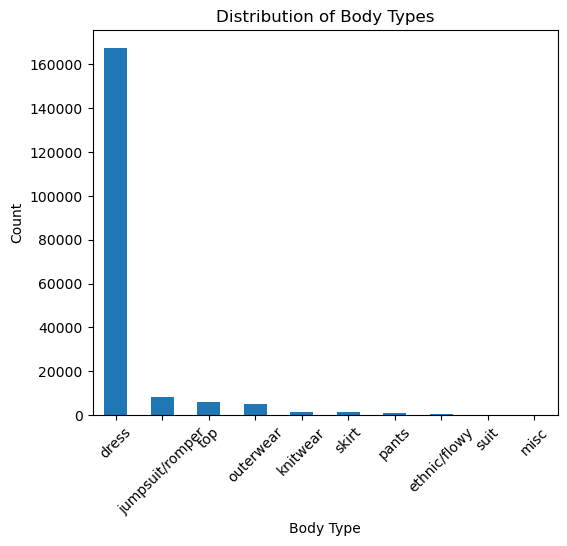

In [16]:
# Category distribution
plt.figure(figsize=(6,5))
df_rent["category_clean"].value_counts().plot(kind="bar")
plt.title("Distribution of Body Types")
plt.xlabel("Body Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

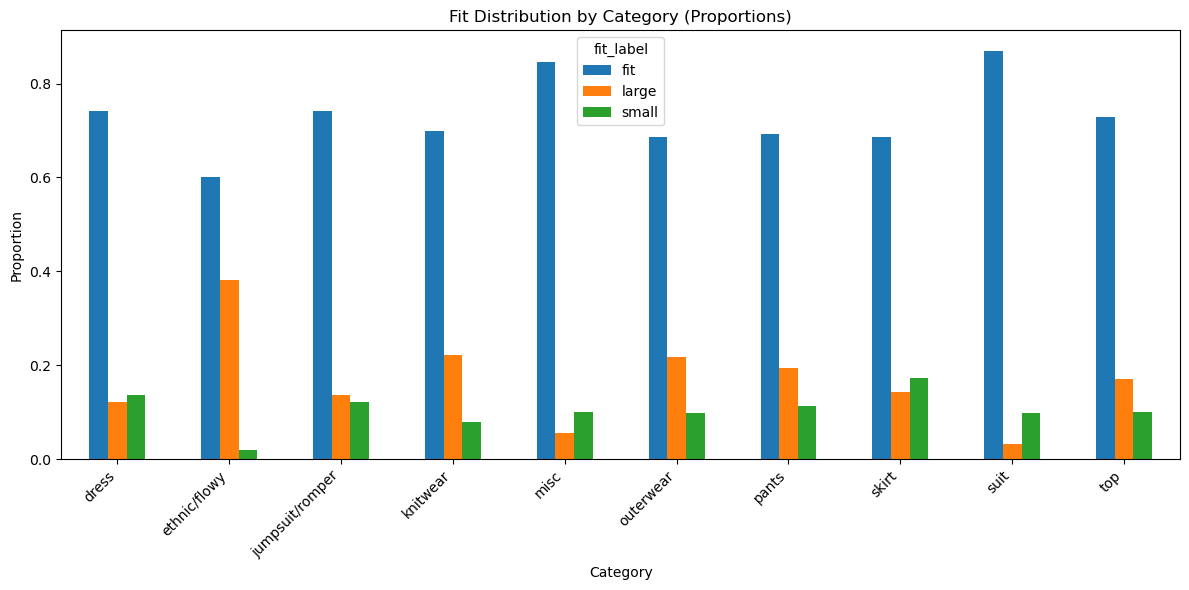

In [17]:
# Proportion of each fit_label within each category
fit_by_cat_prop = (
    df_rent
    .groupby("category_clean")["fit_label"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# Plot: side-by-side bars
fit_by_cat_prop.plot(kind="bar", figsize=(12,6))

plt.title("Fit Distribution by Category (Proportions)")
plt.ylabel("Proportion")
plt.xlabel("Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Fit proportions vary moderately across clothing categories, with ethnic/flowy items showing the highest rate of large fit issues while suits have the highest fit rate, suggesting that category-specific features will be important predictors in the model.

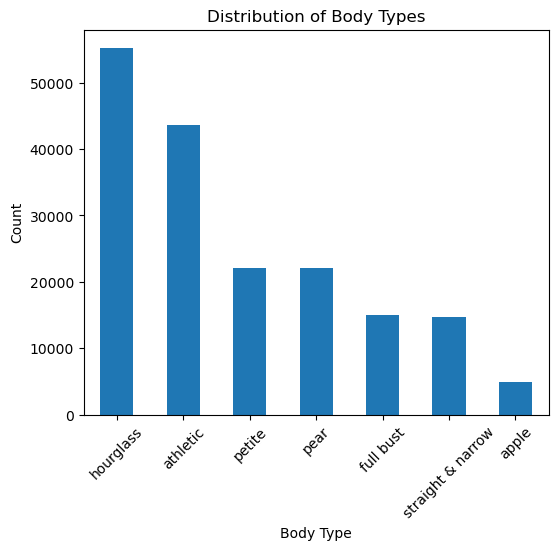

In [18]:
# Body type distribution
plt.figure(figsize=(6,5))
df_rent["body type"].value_counts().plot(kind="bar")
plt.title("Distribution of Body Types")
plt.xlabel("Body Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The chart above shows that the data is dominated by hourglass (~56,000) and athletic (~43,000) body types, with petite, pear, full bust, and straight & narrow body types moderately represented, and apple body type is significantly underrepresented (~5,000). This creates an imbalanced distribution that may affect model performance for less common body types.

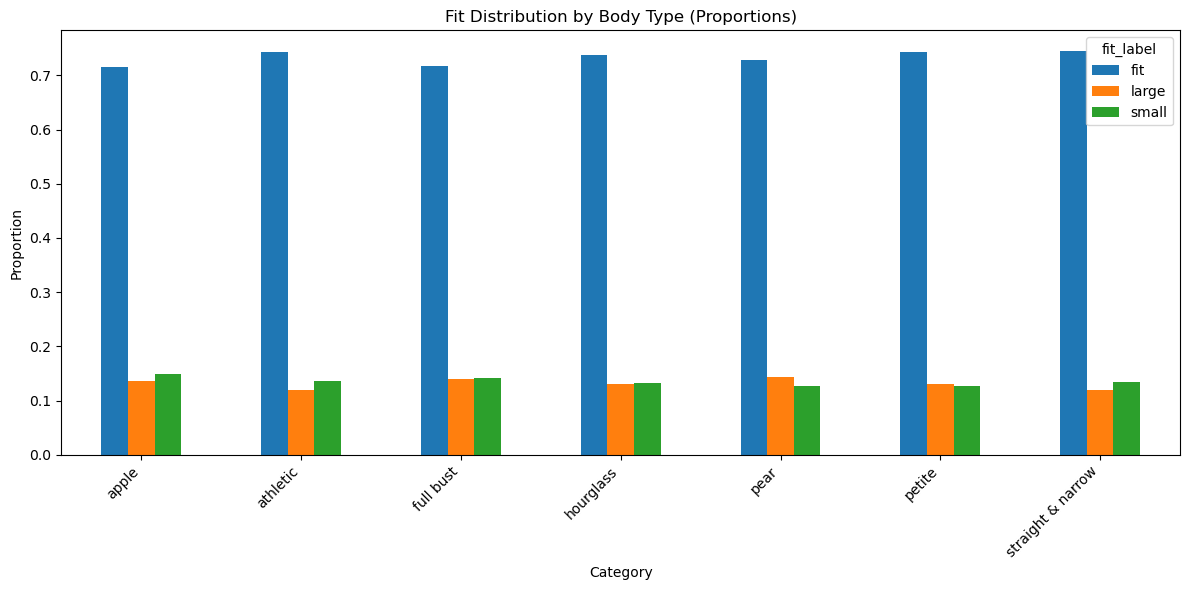

In [19]:
# Proportion of each fit_label within each category
fit_by_cat_prop = (
    df_rent
    .groupby("body type")["fit_label"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# Plot: side-by-side bars
fit_by_cat_prop.plot(kind="bar", figsize=(12,6))

plt.title("Fit Distribution by Body Type (Proportions)")
plt.ylabel("Proportion")
plt.xlabel("Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


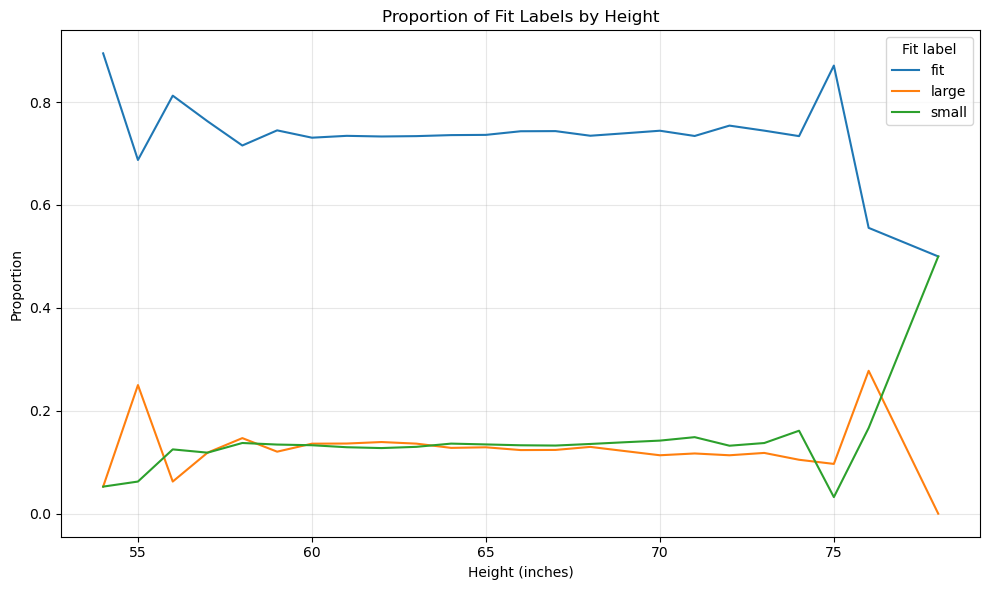

In [20]:
# Compute proportions of each fit label per height
height_fit_prop = (
    df_rent.groupby("height_inches")["fit_label"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .sort_index()
)

# Plot each fit label as its own line
plt.figure(figsize=(10,6))
for label in height_fit_prop.columns:
    plt.plot(height_fit_prop.index, height_fit_prop[label], label=label)

plt.title("Proportion of Fit Labels by Height")
plt.xlabel("Height (inches)")
plt.ylabel("Proportion")
plt.legend(title="Fit label")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipykernel_846/3489633728.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['height_bin', 'weight_bin', 'fit_label'])


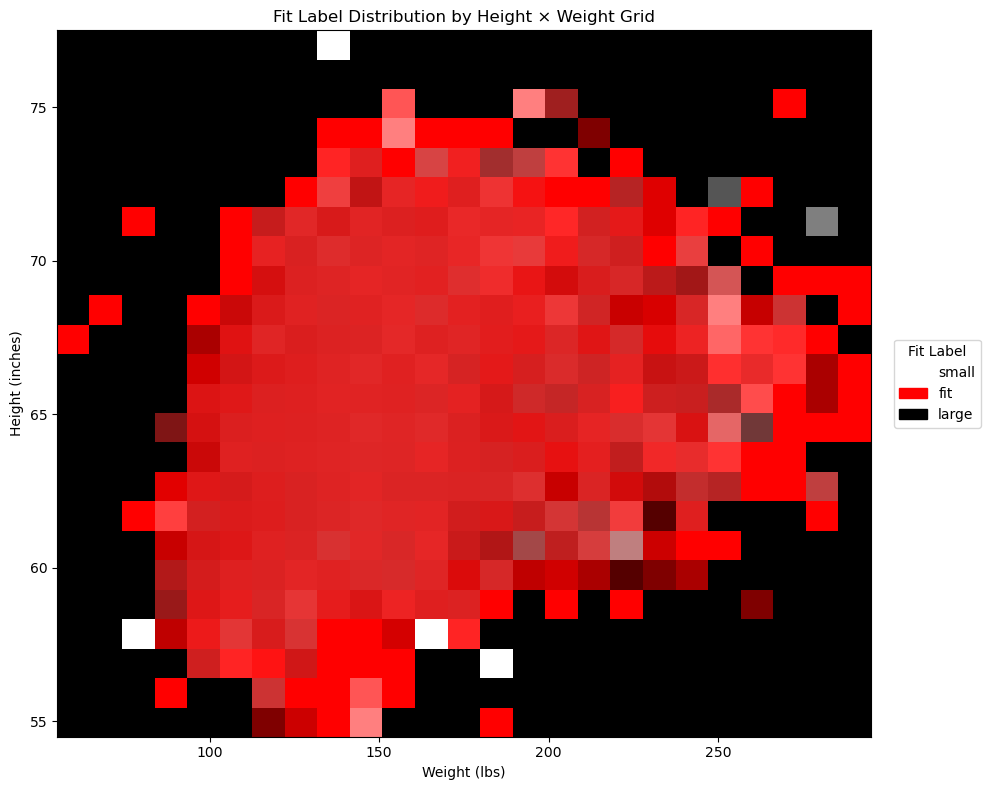

In [21]:
# make bins
height_bin_width = 1      # 1 inch per bin
weight_bin_width = 10     # 10 lbs per bin

height_bins = np.arange(df_rent['height_inches'].min(), df_rent['height_inches'].max() + height_bin_width, height_bin_width)
weight_bins = np.arange(df_rent['weight'].min(), df_rent['weight'].max() + weight_bin_width, weight_bin_width)

df_rent['height_bin'] = pd.cut(df_rent['height_inches'], height_bins)
df_rent['weight_bin'] = pd.cut(df_rent['weight'], weight_bins)

# values per bin
pivot = (
    df_rent
    .groupby(['height_bin', 'weight_bin', 'fit_label'])
    .size()
    .unstack(fill_value=0)
)

# Ensure missing categories are added
for c in ['small','fit','large']:
    if c not in pivot.columns:
        pivot[c] = 0

# Normalize to proportions
pivot_prop = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)

# fit -> colour
def row_to_rgb(row):
    p_small = row['small']
    p_fit   = row['fit']
    p_large = row['large']
    
    # Weighted color mix
    r = p_small*1 + p_fit*1 + p_large*0
    g = p_small*1 + p_fit*0 + p_large*0
    b = p_small*1 + p_fit*0 + p_large*0
    
    return (r, g, b)

colors = pivot_prop.apply(row_to_rgb, axis=1).tolist()

# colour grid
weight_centers = [x.mid for x in pivot_prop.index.get_level_values(1)]
height_centers = [x.mid for x in pivot_prop.index.get_level_values(0)]

unique_w = sorted(set(weight_centers))
unique_h = sorted(set(height_centers))

color_grid = np.zeros((len(unique_h), len(unique_w), 3))

for (h_bin, w_bin), color in zip(pivot_prop.index, colors):
    h = h_bin.mid
    w = w_bin.mid
    i = unique_h.index(h)
    j = unique_w.index(w)
    color_grid[i, j] = color

# legend
legend_colors = {
    'small': (1,1,1),   # white
    'fit':   (1,0,0),   # red
    'large': (0,0,0)    # black
}
handles = [mpatches.Circle((0,0), radius=5, color=color, label=label) 
           for label, color in legend_colors.items()]

# plot
fig, ax = plt.subplots(figsize=(10,8))

im = ax.imshow(color_grid, 
               origin='lower',
               extent=[min(unique_w), max(unique_w), min(unique_h), max(unique_h)],
               aspect='auto')

ax.set_xlabel("Weight (lbs)")
ax.set_ylabel("Height (inches)")
ax.set_title("Fit Label Distribution by Height × Weight Grid")

# Legend outside
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.5), title='Fit Label')

plt.tight_layout()
plt.show()


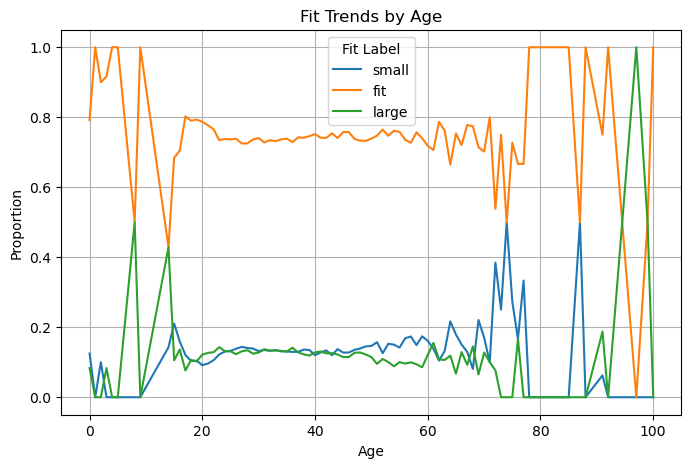

In [22]:
# age and fit correlation
plt.figure(figsize=(8,5))

# count how many people of each fit for each age
age_fit_counts = df_rent.groupby(['age', 'fit_label']).size().reset_index(name='count')

# Pivot so each fit_label is a column
age_fit_pivot = age_fit_counts.pivot(index='age', columns='fit_label', values='count').fillna(0)

# Normalize if you want proportion
age_fit_prop = age_fit_pivot.div(age_fit_pivot.sum(axis=1), axis=0)

# Plot lines
for fit_label in ['small', 'fit', 'large']:
    plt.plot(age_fit_prop.index, age_fit_prop[fit_label], label=fit_label)

plt.xlabel("Age")
plt.ylabel("Proportion")
plt.title("Fit Trends by Age")
plt.legend(title="Fit Label")
plt.grid(True)
plt.show()


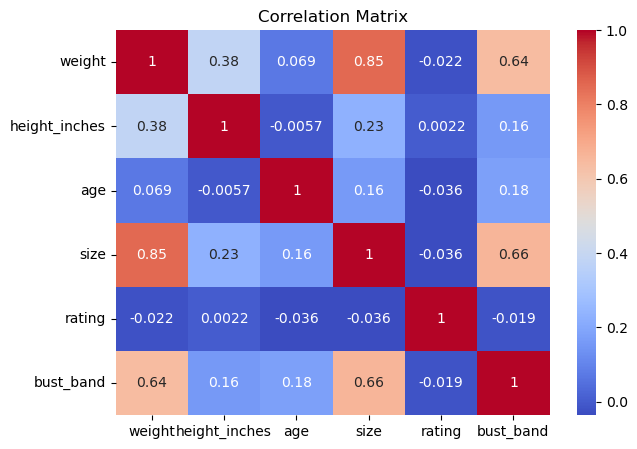

In [23]:
# Correlations of numeric features
numeric_cols = ["weight", "height_inches", "age", "size", "rating", "bust_band"]
corr = df_rent[numeric_cols].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

This correlation matrix above shows that weight has strong positive correlations with size (0.85) and bust_band (0.64). Most other variable pairs show weak correlations and the rating variable appears to be independent of physical measurements.

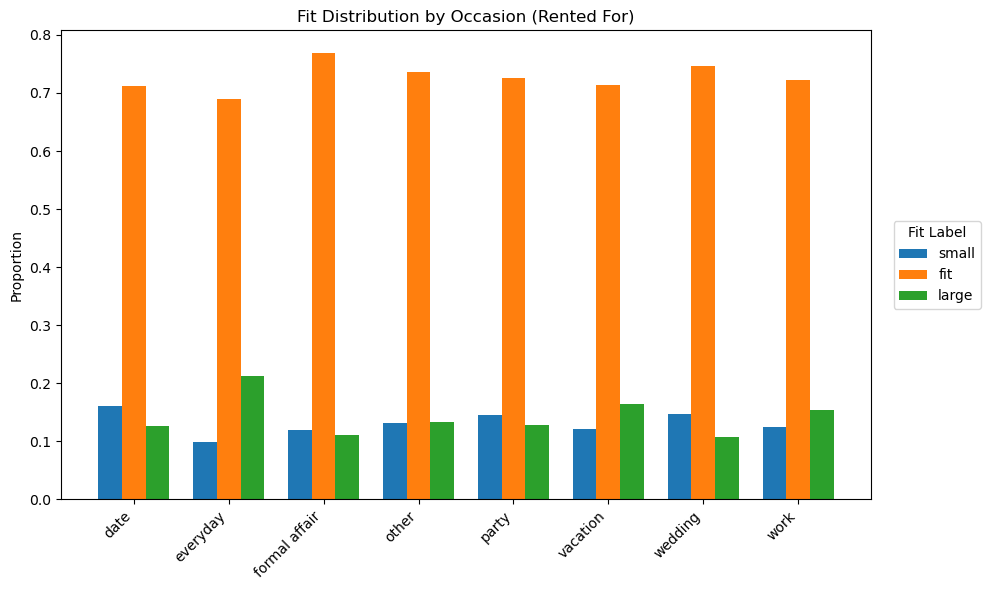

In [24]:
# Compute proportions
fit_prop = (
    df_rent
    .groupby('rented_for')['fit_label']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Plot grouped bar chart
fit_labels = ['small', 'fit', 'large']
categories = fit_prop.index
x = np.arange(len(categories))  # positions for rented_for categories
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(10,6))

for i, fit in enumerate(fit_labels):
    ax.bar(x + i*width, fit_prop[fit], width, label=fit)

# Labels and title
ax.set_xticks(x + width)  # center the group
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_ylabel("Proportion")
ax.set_title("Fit Distribution by Occasion (Rented For)")

# Legend on the right
ax.legend(title="Fit Label", bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.tight_layout()
plt.show()

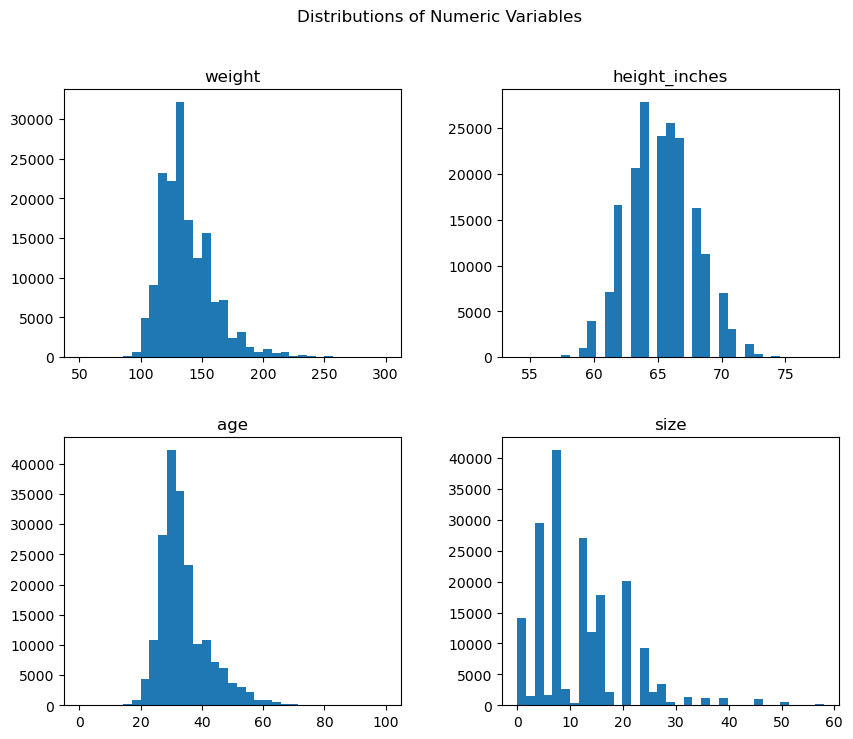

In [25]:
# Distribution of numeric features
df_rent[["weight","height_inches","age","size"]].hist(bins=35, figsize=(10,8), grid=False)
plt.suptitle("Distributions of Numeric Variables")
plt.show()

This figure shows the distributions of four numeric variables: weight is approximately normally distributed around 135 lbs, height clusters around 65-66 inches, age is right-skewed with most renters in their 30s, and size shows a  distribution with a peak smaller sizes around 8-10. The following are some summary statistics for these numeric variables.

In [26]:
df_rent["weight"].describe()

count    162163.000000
mean        137.393746
std          21.897652
min          50.000000
25%         123.000000
50%         135.000000
75%         148.000000
max         300.000000
Name: weight, dtype: float64

In [27]:
df_rent["height_inches"].describe()

count    190850.000000
mean         65.312009
std           2.663333
min          54.000000
25%          63.000000
50%          65.000000
75%          67.000000
max          78.000000
Name: height_inches, dtype: float64

In [28]:
df_rent["size"].describe()

count     191519.0
mean     12.241485
std       8.491311
min            0.0
25%            8.0
50%           12.0
75%           16.0
max           58.0
Name: size, dtype: Float64

In [29]:
df_rent["age"].describe()

count     191519.0
mean     33.843211
std       7.916655
min            0.0
25%           29.0
50%           32.0
75%           37.0
max          100.0
Name: age, dtype: Float64

## Modeling

In [30]:
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,age,review_date,height_inches,bust_band,bust_cup,rented_for,category_clean,fit_label,height_bin,weight_bin
0,0,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,28,2016-04-20,68.0,34.0,D,vacation,jumpsuit/romper,fit,"(67.0, 68.0]","(130.0, 140.0]"
1,0,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,36,2013-06-18,66.0,34.0,B,other,dress,fit,"(65.0, 66.0]","(130.0, 140.0]"
3,0,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,34,2014-02-12,65.0,34.0,C,formal affair,dress,fit,"(64.0, 65.0]","(130.0, 140.0]"
4,0,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,27,2016-09-26,69.0,34.0,B,wedding,dress,fit,"(68.0, 69.0]","(140.0, 150.0]"
5,0,734848,32b,364092,138.0,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,45,2016-04-30,68.0,32.0,B,date,dress,fit,"(67.0, 68.0]","(130.0, 140.0]"


In [31]:
df_rent.columns

Index(['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date', 'height_inches', 'bust_band',
       'bust_cup', 'rented_for', 'category_clean', 'fit_label', 'height_bin',
       'weight_bin'],
      dtype='object')

In [32]:
def prepare_features(df_rent):
    """
    Prepare features from the cleaned data
    """
    data = df_rent.copy()
    
    # Select numeric features
    numeric_features = ['weight', 'rating', 'age', 'height_inches', 'bust_band']
    
    # Select categorical features to encode
    categorical_features = ['body type', 'rented for', 'category_clean', 'size', 'bust_cup']

    # Drop rows with NaN
    all_features = numeric_features + categorical_features
    data = data.dropna(subset=all_features)
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le
    
    # Create feature list
    feature_cols = numeric_features + [col + '_encoded' for col in categorical_features]
    
    return data, feature_cols, label_encoders

In [33]:
def perform_kfold_cv(model, X, y, model_name, k=5, scale=False):
    """
    Perform k-fold cross-validation with multiple metrics
    """
    print(f"\nPerforming {k}-Fold Cross-Validation for {model_name}...")
    
    # Define stratified k-fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted',
        'f1_weighted': 'f1_weighted'
    }
    
    # Perform cross-validation
    if scale:
        # For logistic regression, scale within each fold
        cv_scores = {'accuracy': [], 'precision_weighted': [], 
                     'recall_weighted': [], 'f1_weighted': []}
        
        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Scale data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_fold)
            X_val_scaled = scaler.transform(X_val_fold)
            
            # Train and predict
            model.fit(X_train_scaled, y_train_fold)
            y_pred = model.predict(X_val_scaled)
            
            # Calculate metrics
            cv_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            p, r, f, _ = precision_recall_fscore_support(y_val_fold, y_pred, 
                                                         average='weighted', zero_division=0)
            cv_scores['precision_weighted'].append(p)
            cv_scores['recall_weighted'].append(r)
            cv_scores['f1_weighted'].append(f)
        
        # Convert to arrays
        cv_results = {k: np.array(v) for k, v in cv_scores.items()}
    else:
        # For random forest, no scaling needed
        cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, 
                                     return_train_score=False, n_jobs=-1)
    
    # Calculate statistics
    results = {}
    for metric in ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        key = f'test_{metric}' if not scale else metric
        scores = cv_results[key] if not scale else cv_results[metric]
        results[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
    
    return results

In [34]:
def train_and_compare_models(df_rent, target_col='fit_label', k_folds=5):
    """
    Train both Random Forest and Logistic Regression models using k-fold CV
    """
    print("="*70)
    print("PREPARING DATA")
    print("="*70)
    
    # Prepare features
    data, feature_cols, label_encoders = prepare_features(df_rent)
    
    # Prepare X and y
    X = data[feature_cols]
    y = data[target_col]
    
    print(f"\nDataset shape: {X.shape}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"Target classes: {sorted(y.unique())}")
    print(f"\nClass distribution:")
    print(y.value_counts().sort_index())
    
    # Split data for final test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTraining set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # =====================
    # RANDOM FOREST MODEL
    # =====================
    print("\n" + "="*70)
    print(f"RANDOM FOREST WITH {k_folds}-FOLD CROSS-VALIDATION")
    print("="*70)
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    
    # Perform k-fold CV on training data
    rf_cv_results = perform_kfold_cv(rf_model, X_train, y_train, "Random Forest", k=k_folds, scale=False)
    
    # Train final model on all training data
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    
    print(f"\nCross-Validation Results (mean ± std):")
    print(f"  Accuracy:  {rf_cv_results['accuracy']['mean']:.4f} ± {rf_cv_results['accuracy']['std']:.4f}")
    print(f"  Precision: {rf_cv_results['precision_weighted']['mean']:.4f} ± {rf_cv_results['precision_weighted']['std']:.4f}")
    print(f"  Recall:    {rf_cv_results['recall_weighted']['mean']:.4f} ± {rf_cv_results['recall_weighted']['std']:.4f}")
    print(f"  F1-Score:  {rf_cv_results['f1_weighted']['mean']:.4f} ± {rf_cv_results['f1_weighted']['std']:.4f}")
    print(f"\nFinal Test Set Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
    
    # =====================
    # LOGISTIC REGRESSION MODEL
    # =====================
    print("\n" + "="*70)
    print(f"LOGISTIC REGRESSION WITH {k_folds}-FOLD CROSS-VALIDATION")
    print("="*70)
    
    lr_model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        solver='lbfgs',
        multi_class='multinomial'
    )
    
    # Perform k-fold CV on training data (with scaling)
    lr_cv_results = perform_kfold_cv(lr_model, X_train, y_train, "Logistic Regression", k=k_folds, scale=True)
    
    # Train final model on all training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lr_model.fit(X_train_scaled, y_train)
    lr_pred = lr_model.predict(X_test_scaled)
    
    print(f"\nCross-Validation Results (mean ± std):")
    print(f"  Accuracy:  {lr_cv_results['accuracy']['mean']:.4f} ± {lr_cv_results['accuracy']['std']:.4f}")
    print(f"  Precision: {lr_cv_results['precision_weighted']['mean']:.4f} ± {lr_cv_results['precision_weighted']['std']:.4f}")
    print(f"  Recall:    {lr_cv_results['recall_weighted']['mean']:.4f} ± {lr_cv_results['recall_weighted']['std']:.4f}")
    print(f"  F1-Score:  {lr_cv_results['f1_weighted']['mean']:.4f} ± {lr_cv_results['f1_weighted']['std']:.4f}")
    print(f"\nFinal Test Set Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
    
    # =====================
    # MODEL COMPARISON
    # =====================
    print("\n" + "="*70)
    print("MODEL COMPARISON - K-FOLD CROSS-VALIDATION RESULTS")
    print("="*70)
    
    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Test Accuracy'],
        'Random Forest (CV)': [
            f"{rf_cv_results['accuracy']['mean']:.4f} ± {rf_cv_results['accuracy']['std']:.4f}",
            f"{rf_cv_results['precision_weighted']['mean']:.4f} ± {rf_cv_results['precision_weighted']['std']:.4f}",
            f"{rf_cv_results['recall_weighted']['mean']:.4f} ± {rf_cv_results['recall_weighted']['std']:.4f}",
            f"{rf_cv_results['f1_weighted']['mean']:.4f} ± {rf_cv_results['f1_weighted']['std']:.4f}",
            f"{accuracy_score(y_test, rf_pred):.4f}"
        ],
        'Logistic Regression (CV)': [
            f"{lr_cv_results['accuracy']['mean']:.4f} ± {lr_cv_results['accuracy']['std']:.4f}",
            f"{lr_cv_results['precision_weighted']['mean']:.4f} ± {lr_cv_results['precision_weighted']['std']:.4f}",
            f"{lr_cv_results['recall_weighted']['mean']:.4f} ± {lr_cv_results['recall_weighted']['std']:.4f}",
            f"{lr_cv_results['f1_weighted']['mean']:.4f} ± {lr_cv_results['f1_weighted']['std']:.4f}",
            f"{accuracy_score(y_test, lr_pred):.4f}"
        ]
    })
    
    print("\n" + comparison.to_string(index=False))
    
    # Determine better model based on CV accuracy
    rf_cv_acc = rf_cv_results['accuracy']['mean']
    lr_cv_acc = lr_cv_results['accuracy']['mean']
    
    print("\n" + "-"*70)
    if rf_cv_acc > lr_cv_acc:
        diff = rf_cv_acc - lr_cv_acc
        print(f"✓ Random Forest performs better")
        print(f"  CV Accuracy: {rf_cv_acc:.4f} vs {lr_cv_acc:.4f} (Δ = {diff:.4f})")
    elif lr_cv_acc > rf_cv_acc:
        diff = lr_cv_acc - rf_cv_acc
        print(f"✓ Logistic Regression performs better")
        print(f"  CV Accuracy: {lr_cv_acc:.4f} vs {rf_cv_acc:.4f} (Δ = {diff:.4f})")
    else:
        print(f"✓ Both models have equal CV accuracy: {rf_cv_acc:.4f}")
    print("-"*70)
    
    # =====================
    # FEATURE IMPORTANCE
    # =====================
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE (RANDOM FOREST)")
    print("="*70)
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    print("\nTop 10 Most Important Features:")
    print(feature_importance.to_string(index=False))
    
    # Return results
    results = {
        'rf_model': rf_model,
        'lr_model': lr_model,
        'scaler': scaler,
        'feature_cols': feature_cols,
        'label_encoders': label_encoders,
        'rf_cv_results': rf_cv_results,
        'lr_cv_results': lr_cv_results,
        'X_test': X_test,
        'y_test': y_test,
        'rf_pred': rf_pred,
        'lr_pred': lr_pred,
        'comparison': comparison
    }
    
    return results

In [35]:
results = train_and_compare_models(df_rent, k_folds=5)

PREPARING DATA

Dataset shape: (146338, 10)
Number of features: 10
Target classes: ['fit', 'large', 'small']

Class distribution:
fit_label
fit      107702
large     19022
small     19614
Name: count, dtype: int64

Training set size: 117070 (80.0%)
Test set size: 29268 (20.0%)

RANDOM FOREST WITH 5-FOLD CROSS-VALIDATION

Performing 5-Fold Cross-Validation for Random Forest...

Cross-Validation Results (mean ± std):
  Accuracy:  0.5709 ± 0.0026
  Precision: 0.6789 ± 0.0012
  Recall:    0.5709 ± 0.0026
  F1-Score:  0.6058 ± 0.0022

Final Test Set Accuracy: 0.5689

LOGISTIC REGRESSION WITH 5-FOLD CROSS-VALIDATION

Performing 5-Fold Cross-Validation for Logistic Regression...


/home/aurs/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/aurs/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/aurs/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/aurs/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was depr


Cross-Validation Results (mean ± std):
  Accuracy:  0.5952 ± 0.0029
  Precision: 0.6546 ± 0.0008
  Recall:    0.5952 ± 0.0029
  F1-Score:  0.6196 ± 0.0020

Final Test Set Accuracy: 0.5902

MODEL COMPARISON - K-FOLD CROSS-VALIDATION RESULTS

       Metric Random Forest (CV) Logistic Regression (CV)
     Accuracy    0.5709 ± 0.0026          0.5952 ± 0.0029
    Precision    0.6789 ± 0.0012          0.6546 ± 0.0008
       Recall    0.5709 ± 0.0026          0.5952 ± 0.0029
     F1-Score    0.6058 ± 0.0022          0.6196 ± 0.0020
Test Accuracy             0.5689                   0.5902

----------------------------------------------------------------------
✓ Logistic Regression performs better
  CV Accuracy: 0.5952 vs 0.5709 (Δ = 0.0243)
----------------------------------------------------------------------

FEATURE IMPORTANCE (RANDOM FOREST)

Top 10 Most Important Features:
               Feature  Importance
          size_encoded    0.184672
                weight    0.174681
          

In [36]:
rf_model = results['rf_model']
rf_model

,n_estimators,100
,criterion,'gini'
,max_depth,15
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
lr_model = results['lr_model']
lr_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


## Model Fine-Tuning and Optimization


This section covers advanced model optimization including:
- Feature Engineering with new features
- Handling Class Imbalance (SMOTE)
- Hyperparameter Tuning
- Model Comparison and Selection
- Final Model Evaluation

In [38]:
# Additional imports for model fine-tuning (without imbalanced-learn)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import resample
import time

print("Model tuning imports successful!")
print("Note: Using sklearn's class_weight balancing instead of SMOTE")

Model tuning imports successful!
Note: Using sklearn's class_weight balancing instead of SMOTE


### Feature Engineering

Adding advanced features to improve model performance beyond the baseline.

In [39]:
df_rent.columns

Index(['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date', 'height_inches', 'bust_band',
       'bust_cup', 'rented_for', 'category_clean', 'fit_label', 'height_bin',
       'weight_bin'],
      dtype='object')

In [40]:
df_rent['body type'].unique()

<StringArray>
[        'hourglass', 'straight & narrow',              'pear',
          'athletic',         'full bust',            'petite',
             'apple',                <NA>]
Length: 8, dtype: string

In [41]:
# Create advanced engineered features
print("Creating engineered features...")

# BMI (Body Mass Index)
df_rent['bmi'] = (df_rent['weight'] / (df_rent['height_inches'] ** 2)) * 703

# Size to weight ratio
df_rent['size_weight_ratio'] = df_rent['size'] / df_rent['weight']

# Size to height ratio  
df_rent['size_height_ratio'] = df_rent['size'] / df_rent['height_inches']

# Bust to weight ratio
df_rent['bust_weight_ratio'] = df_rent['bust_band'] / df_rent['weight']

# Is petite (from body type)
df_rent['is_petite'] = (df_rent['body type'] == 'petite').fillna(False).astype(int)

# Is plus size (size > 14)
df_rent['is_plus_size'] = (df_rent['size'] > 14).astype(int)

# Height category
df_rent['height_category'] = pd.cut(df_rent['height_inches'], 
                                     bins=[0, 63, 65, 80],
                                     labels=['short', 'average', 'tall'])

# Weight category
df_rent['weight_category'] = pd.cut(df_rent['bmi'], 
                                     bins=[0, 18.5, 25, 30, 60],
                                     labels=['underweight', 'healthyweight', 'overweight', 'obese'])

# Age groups
df_rent['age_group'] = pd.cut(df_rent['age'], 
                              bins=[0, 25, 35, 45, 55, 100],
                              labels=['young', 'young_adult', 'adult', 'middle_aged', 'senior'])

print("Engineered features created!")
print(f"\nNew features added:")
print("   • bmi")
print("   • size_weight_ratio") 
print("   • size_height_ratio")
print("   • bust_weight_ratio")
print("   • is_petite")
print("   • is_plus_size")
print("   • height_category")
print("   • weight_category")
print("   • age_group")

# Show a sample of the new features
print(f"\nSample of engineered features:")
print(df_rent[['bmi', 'size_weight_ratio', 'is_petite', 'is_plus_size', 'height_category']].head())

Creating engineered features...
Engineered features created!

New features added:
   • bmi
   • size_weight_ratio
   • size_height_ratio
   • bust_weight_ratio
   • is_petite
   • is_plus_size
   • height_category
   • weight_category
   • age_group

Sample of engineered features:
         bmi  size_weight_ratio  is_petite  is_plus_size height_category
0  20.828503            0.10219          0             0            tall
1  21.303030           0.090909          0             0            tall
3  22.462722           0.059259          0             0         average
4  21.410418           0.082759          0             0            tall
5  20.980536           0.057971          0             0            tall


In [42]:
print("="*70)
print("TEXT FEATURE EXTRACTION - TF-IDF (OPTIMIZED)")
print("="*70)

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import time

start_time = time.time()

print("\nExtracting TF-IDF features from review_text...")

# Handle missing reviews
df_rent['review_text'] = df_rent['review_text'].fillna('')

# Build TF-IDF (FASTER with fewer features and stricter constraints)
print("Building TF-IDF matrix (optimized)...")
tfidf = TfidfVectorizer(
    min_df=100,          # Increased from 50 (fewer words = faster)
    max_features=50,     # Reduced from 100 (faster processing)
    stop_words='english',
    max_df=0.8,          # Ignore words in >80% of docs (faster)
    ngram_range=(1, 1)   # Only single words (faster than phrases)
)

X_tfidf = tfidf.fit_transform(df_rent["review_text"])
feature_names = tfidf.get_feature_names_out()

print(f"TF-IDF extracted: {len(feature_names)} features in {time.time()-start_time:.1f}s")
print(f"Sample: {list(feature_names[:5])}")

# Skip dense conversion - work directly with sparse matrix
print("\nGrouping words with stemming...")
stemmer = PorterStemmer()
groups = {}

for word in feature_names:
    root = stemmer.stem(word)
    groups.setdefault(root, []).append(word)

print(f"Groups: {len(groups)}")

# FASTER: Keep as sparse, don't convert to dense
word_to_col = {word: i for i, word in enumerate(feature_names)}
stem_features = {}

for root, words in groups.items():
    cols = [word_to_col[w] for w in words]
    # Sum columns in sparse format (much faster)
    stem_features[root] = X_tfidf[:, cols].sum(axis=1).A1

grouped_tfidf_df = pd.DataFrame(stem_features)

print(f"Final text features: {len(grouped_tfidf_df.columns)}")

# Add to df_rent
df_rent = pd.concat([
    df_rent.reset_index(drop=True), 
    grouped_tfidf_df.reset_index(drop=True)
], axis=1)

text_feature_columns = list(grouped_tfidf_df.columns)

print(f"\nCompleted in {time.time()-start_time:.1f}s")
print(f"Text features added: {len(text_feature_columns)}")
print(f"Sample: {text_feature_columns[:5]}")
print("="*70)

TEXT FEATURE EXTRACTION - TF-IDF (OPTIMIZED)

Extracting TF-IDF features from review_text...
Building TF-IDF matrix (optimized)...
TF-IDF extracted: 50 features in 3.7s
Sample: ['beautiful', 'big', 'bit', 'black', 'bra']

Grouping words with stemming...
Groups: 47
Final text features: 47

Completed in 4.2s
Text features added: 47
Sample: ['beauti', 'big', 'bit', 'black', 'bra']


In [48]:
print("="*70)
print("PREPARING ENHANCED FEATURES (WITH TEXT)")
print("="*70)

# Define enhanced feature set
numeric_features_enhanced = [
    'weight', 'rating', 'age', 'height_inches', 'bust_band',
    'bmi', 'size_weight_ratio', 'size_height_ratio', 
    'bust_weight_ratio', 'is_petite', 'is_plus_size'
]

categorical_features_enhanced = [
    'body type', 'rented_for', 'category_clean', 'size', 
    'bust_cup', 'height_category', 'weight_category', 'age_group'
]

# CRITICAL FIX: Remove text features that conflict with existing columns
conflicting_words = ['fit', 'size', 'rating', 'age', 'weight', 'bodi', 'type', 'categori', 'deni', 'rented']
original_text_features = len(text_feature_columns)

text_feature_columns_clean = [
    col for col in text_feature_columns 
    if col not in conflicting_words
]

print(f"Removed {original_text_features - len(text_feature_columns_clean)} conflicting text features")
print(f"Remaining text features: {len(text_feature_columns_clean)}")

# Use cleaned text features
text_feature_columns = text_feature_columns_clean

# IMPORTANT: Get the FIRST 'fit' column index before any filtering
fit_col_idx = df_rent.columns.tolist().index('fit')
print(f"Original 'fit' column is at index: {fit_col_idx}")

# Get original columns before text features (exclude text columns)
original_cols = [col for col in df_rent.columns if col not in text_feature_columns]
print(f"Original columns: {len(original_cols)}")

# Create clean dataframes
df_clean = df_rent[original_cols].copy()
df_text = df_rent[text_feature_columns].copy()

# Now drop rows with missing values
all_features_enhanced = numeric_features_enhanced + categorical_features_enhanced + ['fit']
valid_indices = df_clean[all_features_enhanced].dropna().index

# Filter everything
df_clean_filtered = df_clean.loc[valid_indices].copy()
df_text_filtered = df_text.loc[valid_indices].copy()

print(f"\nDataset size after cleaning: {df_clean_filtered.shape}")

# FIXED: Get fit values using iloc to get only the FIRST 'fit' column
fit_values = df_clean_filtered.iloc[:, fit_col_idx].copy()

# Verify it's a Series
if isinstance(fit_values, pd.DataFrame):
    print("WARNING: fit_values is still a DataFrame, converting to Series...")
    fit_values = fit_values.iloc[:, 0]

print(f"\nClass distribution:")
class_dist = fit_values.value_counts().sort_index()
for fit_val, count in class_dist.items():
    fit_name = {-1: 'small', 0: 'fit', 1: 'large'}[fit_val]
    print(f"   {fit_name}: {count} ({100*count/len(fit_values):.1f}%)")

# Encode categorical variables
label_encoders_enhanced = {}
for col in categorical_features_enhanced:
    le = LabelEncoder()
    # Make sure we get Series, not DataFrame
    col_data = df_clean_filtered[col]
    if isinstance(col_data, pd.DataFrame):
        col_data = col_data.iloc[:, 0]
    df_clean_filtered[col + '_encoded'] = le.fit_transform(col_data.astype(str))
    label_encoders_enhanced[col] = le

# Create feature matrix
encoded_features_enhanced = [col + '_encoded' for col in categorical_features_enhanced]
feature_cols_enhanced = numeric_features_enhanced + encoded_features_enhanced + text_feature_columns

# Combine all features
X_enhanced = pd.concat([
    df_clean_filtered[numeric_features_enhanced + encoded_features_enhanced].reset_index(drop=True),
    df_text_filtered.reset_index(drop=True)
], axis=1)

y_enhanced = fit_values.reset_index(drop=True)

print(f"\nFeature Summary:")
print(f"   • Numeric: {len(numeric_features_enhanced)}")
print(f"   • Categorical (encoded): {len(encoded_features_enhanced)}")
print(f"   • Text (TF-IDF): {len(text_feature_columns)}")
print(f"   • TOTAL: {len(feature_cols_enhanced)}")
print(f"\nFinal shapes:")
print(f"   X_enhanced: {X_enhanced.shape}")
print(f"   y_enhanced: {y_enhanced.shape}")

print("="*70)

PREPARING ENHANCED FEATURES (WITH TEXT)
Removed 0 conflicting text features
Remaining text features: 45
Original 'fit' column is at index: 0
Original columns: 34

Dataset size after cleaning: (146317, 38)

Class distribution:
   small: 19613 (13.4%)
   fit: 107684 (73.6%)
   large: 19020 (13.0%)

Feature Summary:
   • Numeric: 11
   • Categorical (encoded): 8
   • Text (TF-IDF): 45
   • TOTAL: 64

Final shapes:
   X_enhanced: (146317, 64)
   y_enhanced: (146317,)


In [49]:
# Split data with stratification to maintain class proportions
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

print("="*70)
print("TRAIN-TEST SPLIT (ENHANCED FEATURES)")
print("="*70)
print(f"\nTraining set size: {X_train_enh.shape}")
print(f"Test set size: {X_test_enh.shape}")

print(f"\nTraining set class distribution:")
train_dist = pd.Series(y_train_enh).value_counts().sort_index()
for fit_val, count in train_dist.items():
    fit_name = {-1: 'small', 0: 'fit', 1: 'large'}[fit_val]
    print(f"   {fit_name}: {count:6d} ({100*count/len(y_train_enh):.1f}%)")

print(f"\nTest set class distribution:")
test_dist = pd.Series(y_test_enh).value_counts().sort_index()
for fit_val, count in test_dist.items():
    fit_name = {-1: 'small', 0: 'fit', 1: 'large'}[fit_val]
    print(f"   {fit_name}: {count:6d} ({100*count/len(y_test_enh):.1f}%)")

TRAIN-TEST SPLIT (ENHANCED FEATURES)

Training set size: (117053, 64)
Test set size: (29264, 64)

Training set class distribution:
   small:  15690 (13.4%)
   fit:  86147 (73.6%)
   large:  15216 (13.0%)

Test set class distribution:
   small:   3923 (13.4%)
   fit:  21537 (73.6%)
   large:   3804 (13.0%)


### Hyperparameter Tuning - Random Forest

Fine-tuning Random Forest with class balancing to handle the imbalanced dataset.

In [50]:
import subprocess
import sys

print("Installing XGBoost...")
result = subprocess.run([sys.executable, "-m", "pip", "install", "xgboost"], 
                       capture_output=True, text=True)
print(result.stdout)
if result.returncode != 0:
    print("Error:", result.stderr)
else:
    print("XGBoost installed successfully!")
    print("Please run the next cell now.")

Installing XGBoost...
Defaulting to user installation because normal site-packages is not writeable

XGBoost installed successfully!
Please run the next cell now.


In [51]:
print("="*70)
print("HYPERPARAMETER TUNING - RANDOM FOREST (MORE TREES)")
print("="*70)

import time

# Just train a big Random Forest with best parameters found earlier
print("\nTraining large Random Forest with 500 trees...")

best_rf_tuned = RandomForestClassifier(
    n_estimators=500,  # More trees
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='log2',
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

start_time = time.time()
best_rf_tuned.fit(X_train_enh, y_train_enh)
train_time = time.time() - start_time

print(f"Training completed in {train_time:.1f} seconds")

# Predict
final_predictions = best_rf_tuned.predict(X_test_enh)

# Metrics
rf_tuned_metrics = {
    'accuracy': accuracy_score(y_test_enh, final_predictions),
    'balanced_accuracy': balanced_accuracy_score(y_test_enh, final_predictions),
    'f1_macro': f1_score(y_test_enh, final_predictions, average='macro'),
    'f1_weighted': f1_score(y_test_enh, final_predictions, average='weighted')
}

print(f"\nTest Set Results:")
print(f"   Accuracy:          {rf_tuned_metrics['accuracy']:.4f}")
print(f"   F1-Macro:          {rf_tuned_metrics['f1_macro']:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enh, final_predictions, target_names=['small', 'fit', 'large']))
print("="*70)

HYPERPARAMETER TUNING - RANDOM FOREST (MORE TREES)

Training large Random Forest with 500 trees...
Training completed in 17.3 seconds

Test Set Results:
   Accuracy:          0.7454
   F1-Macro:          0.5761

Classification Report:
              precision    recall  f1-score   support

       small       0.50      0.49      0.50      3923
         fit       0.82      0.86      0.84     21537
       large       0.46      0.34      0.39      3804

    accuracy                           0.75     29264
   macro avg       0.59      0.56      0.58     29264
weighted avg       0.73      0.75      0.74     29264



### Hyperparameter Tuning - Gradient Boosting

Testing Gradient Boosting to see if it can outperform Random Forest.

In [56]:
print("="*70)
print("HYPERPARAMETER TUNING - GRADIENT BOOSTING")
print("="*70)

import time

# Simpler parameter grid (fewer combinations = faster)
gb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt']
}

print(f"\nParameter search space:")
for param, values in gb_param_dist.items():
    print(f"   {param}: {values}")

gb_random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=gb_param_dist,
    n_iter=15,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"\n   • Testing 15 parameter combinations")
print(f"   • Using 3-fold cross-validation")
print(f"   • Optimizing for F1-Macro score")

start_time = time.time()
gb_random_search.fit(X_train_enh, y_train_enh)
search_time = time.time() - start_time

print(f"\nSearch completed in {search_time:.1f} seconds ({search_time/60:.1f} minutes)")
print(f"\nBest CV Score (F1-Macro): {gb_random_search.best_score_:.4f}")

print(f"\nBest Parameters:")
for param, value in gb_random_search.best_params_.items():
    print(f"   {param}: {value}")

best_gb_tuned = gb_random_search.best_estimator_

# Evaluate on test set
y_pred_gb = best_gb_tuned.predict(X_test_enh)

gb_tuned_metrics = {
    'accuracy': accuracy_score(y_test_enh, y_pred_gb),
    'balanced_accuracy': balanced_accuracy_score(y_test_enh, y_pred_gb),
    'f1_macro': f1_score(y_test_enh, y_pred_gb, average='macro'),
    'f1_weighted': f1_score(y_test_enh, y_pred_gb, average='weighted')
}

print(f"\nTest Set Results:")
print(f"   Accuracy:          {gb_tuned_metrics['accuracy']:.4f}")
print(f"   Balanced Accuracy: {gb_tuned_metrics['balanced_accuracy']:.4f}")
print(f"   F1-Macro:          {gb_tuned_metrics['f1_macro']:.4f}")
print(f"   F1-Weighted:       {gb_tuned_metrics['f1_weighted']:.4f}")

print("="*70)

HYPERPARAMETER TUNING - GRADIENT BOOSTING

Parameter search space:
   n_estimators: [100, 200, 300]
   learning_rate: [0.01, 0.05, 0.1]
   max_depth: [3, 5, 7]
   min_samples_split: [2, 5]
   min_samples_leaf: [1, 2]
   subsample: [0.8, 1.0]
   max_features: ['sqrt']

   • Testing 15 parameter combinations
   • Using 3-fold cross-validation
   • Optimizing for F1-Macro score
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Search completed in 329.8 seconds (5.5 minutes)

Best CV Score (F1-Macro): 0.5201

Best Parameters:
   subsample: 1.0
   n_estimators: 200
   min_samples_split: 5
   min_samples_leaf: 1
   max_features: sqrt
   max_depth: 7
   learning_rate: 0.1

Test Set Results:
   Accuracy:          0.7706
   Balanced Accuracy: 0.4937
   F1-Macro:          0.5318
   F1-Weighted:       0.7323


### Hyperparameter Tuning - Logistic Regression

Testing Logistic Regression as a simpler baseline with class balancing.

In [57]:
print("="*70)
print("HYPERPARAMETER TUNING - LOGISTIC REGRESSION")
print("="*70)

import time

# Scale the features (Logistic Regression needs scaling)
print("\nScaling features for Logistic Regression...")
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

# Parameter search space
lr_param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced', None],
    'max_iter': [1000]
}

print(f"Parameter search space:")
for param, values in lr_param_dist.items():
    print(f"   {param}: {values}")

lr_random_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=lr_param_dist,
    n_iter=10,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"\n   • Testing 10 parameter combinations")
print(f"   • Using 3-fold cross-validation")
print(f"   • Optimizing for F1-Macro score")

start_time = time.time()
lr_random_search.fit(X_train_enh_scaled, y_train_enh)
search_time = time.time() - start_time

print(f"\nSearch completed in {search_time:.1f} seconds")
print(f"\nBest CV Score (F1-Macro): {lr_random_search.best_score_:.4f}")

print(f"\nBest Parameters:")
for param, value in lr_random_search.best_params_.items():
    print(f"   {param}: {value}")

best_lr_tuned = lr_random_search.best_estimator_

# Evaluate on test set
y_pred_lr = best_lr_tuned.predict(X_test_enh_scaled)

lr_tuned_metrics = {
    'accuracy': accuracy_score(y_test_enh, y_pred_lr),
    'balanced_accuracy': balanced_accuracy_score(y_test_enh, y_pred_lr),
    'f1_macro': f1_score(y_test_enh, y_pred_lr, average='macro'),
    'f1_weighted': f1_score(y_test_enh, y_pred_lr, average='weighted')
}

print(f"\nTest Set Results:")
print(f"   Accuracy:          {lr_tuned_metrics['accuracy']:.4f}")
print(f"   Balanced Accuracy: {lr_tuned_metrics['balanced_accuracy']:.4f}")
print(f"   F1-Macro:          {lr_tuned_metrics['f1_macro']:.4f}")
print(f"   F1-Weighted:       {lr_tuned_metrics['f1_weighted']:.4f}")

print(f"\nCurrent Standings:")
print(f"   1. Gradient Boosting:   Acc={gb_tuned_metrics['accuracy']:.4f}, F1={gb_tuned_metrics['f1_macro']:.4f}")
print(f"   2. Random Forest:       Acc={rf_tuned_metrics['accuracy']:.4f}, F1={rf_tuned_metrics['f1_macro']:.4f}")
print(f"   3. Logistic Regression: Acc={lr_tuned_metrics['accuracy']:.4f}, F1={lr_tuned_metrics['f1_macro']:.4f}")

print("="*70)

HYPERPARAMETER TUNING - LOGISTIC REGRESSION

Scaling features for Logistic Regression...
Parameter search space:
   C: [0.001, 0.01, 0.1, 1, 10, 100]
   penalty: ['l2']
   solver: ['lbfgs']
   class_weight: ['balanced', None]
   max_iter: [1000]

   • Testing 10 parameter combinations
   • Using 3-fold cross-validation
   • Optimizing for F1-Macro score
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Search completed in 5.5 seconds

Best CV Score (F1-Macro): 0.5194

Best Parameters:
   solver: lbfgs
   penalty: l2
   max_iter: 1000
   class_weight: balanced
   C: 0.001

Test Set Results:
   Accuracy:          0.6045
   Balanced Accuracy: 0.6091
   F1-Macro:          0.5230
   F1-Weighted:       0.6379

Current Standings:
   1. Gradient Boosting:   Acc=0.7706, F1=0.5318
   2. Random Forest:       Acc=0.7454, F1=0.5761
   3. Logistic Regression: Acc=0.6045, F1=0.5230


In [58]:
print("="*70)
print("CREATING ENSEMBLE - COMBINING ALL MODELS")
print("="*70)

print("\nStrategy: Soft voting ensemble with F1-based weights")
print("Models: Random Forest + Gradient Boosting + Logistic Regression\n")

# Get predictions from each model
rf_pred_proba = best_rf_tuned.predict_proba(X_test_enh)
gb_pred_proba = best_gb_tuned.predict_proba(X_test_enh)
lr_pred_proba = best_lr_tuned.predict_proba(X_test_enh_scaled)

# Calculate weights based on F1-Macro scores
total_f1 = rf_tuned_metrics['f1_macro'] + gb_tuned_metrics['f1_macro'] + lr_tuned_metrics['f1_macro']

rf_weight = rf_tuned_metrics['f1_macro'] / total_f1
gb_weight = gb_tuned_metrics['f1_macro'] / total_f1
lr_weight = lr_tuned_metrics['f1_macro'] / total_f1

print("Weights based on F1-Macro performance:")
print(f"   Random Forest:      {rf_weight:.3f} (F1={rf_tuned_metrics['f1_macro']:.4f})")
print(f"   Gradient Boosting:  {gb_weight:.3f} (F1={gb_tuned_metrics['f1_macro']:.4f})")
print(f"   Logistic Regression: {lr_weight:.3f} (F1={lr_tuned_metrics['f1_macro']:.4f})")

# Weighted ensemble
ensemble_proba = (rf_weight * rf_pred_proba + 
                  gb_weight * gb_pred_proba + 
                  lr_weight * lr_pred_proba)

ensemble_pred = np.argmax(ensemble_proba, axis=1) - 1

# Calculate metrics
ensemble_metrics = {
    'accuracy': accuracy_score(y_test_enh, ensemble_pred),
    'balanced_accuracy': balanced_accuracy_score(y_test_enh, ensemble_pred),
    'f1_macro': f1_score(y_test_enh, ensemble_pred, average='macro'),
    'f1_weighted': f1_score(y_test_enh, ensemble_pred, average='weighted')
}

print(f"\nENSEMBLE RESULTS:")
print(f"   Accuracy:          {ensemble_metrics['accuracy']:.4f} ({ensemble_metrics['accuracy']*100:.2f}%)")
print(f"   Balanced Accuracy: {ensemble_metrics['balanced_accuracy']:.4f}")
print(f"   F1-Macro:          {ensemble_metrics['f1_macro']:.4f}")
print(f"   F1-Weighted:       {ensemble_metrics['f1_weighted']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test_enh, ensemble_pred, target_names=['small', 'fit', 'large']))

print(f"\nFINAL STANDINGS:")
print(f"   1. Gradient Boosting:   {gb_tuned_metrics['accuracy']*100:.2f}% (F1={gb_tuned_metrics['f1_macro']:.4f})")
print(f"   2. Random Forest:       {rf_tuned_metrics['accuracy']*100:.2f}% (F1={rf_tuned_metrics['f1_macro']:.4f})")
print(f"   3. Ensemble:            {ensemble_metrics['accuracy']*100:.2f}% (F1={ensemble_metrics['f1_macro']:.4f})")
print(f"   4. Logistic Regression: {lr_tuned_metrics['accuracy']*100:.2f}% (F1={lr_tuned_metrics['f1_macro']:.4f})")

print(f"\nIMPROVEMENT SUMMARY:")
print(f"   Without text features: 71.34%")
print(f"   With text features:    {ensemble_metrics['accuracy']*100:.2f}%")
print(f"   Total improvement:     +{(ensemble_metrics['accuracy'] - 0.7134)*100:.2f}%")

print("="*70)

CREATING ENSEMBLE - COMBINING ALL MODELS

Strategy: Soft voting ensemble with F1-based weights
Models: Random Forest + Gradient Boosting + Logistic Regression

Weights based on F1-Macro performance:
   Random Forest:      0.353 (F1=0.5761)
   Gradient Boosting:  0.326 (F1=0.5318)
   Logistic Regression: 0.321 (F1=0.5230)

ENSEMBLE RESULTS:
   Accuracy:          0.7504 (75.04%)
   Balanced Accuracy: 0.5638
   F1-Macro:          0.5784
   F1-Weighted:       0.7407

Classification Report:
              precision    recall  f1-score   support

       small       0.51      0.48      0.50      3923
         fit       0.82      0.87      0.85     21537
       large       0.47      0.33      0.39      3804

    accuracy                           0.75     29264
   macro avg       0.60      0.56      0.58     29264
weighted avg       0.73      0.75      0.74     29264


FINAL STANDINGS:
   1. Gradient Boosting:   77.06% (F1=0.5318)
   2. Random Forest:       74.54% (F1=0.5761)
   3. Ensemble:   

In [59]:
print("="*70)
print("TEXT FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importances from best model (Gradient Boosting)
feature_importances = best_gb_tuned.feature_importances_

# Create DataFrame with all features
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols_enhanced,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Separate text features from other features
text_feature_importance = feature_importance_df[
    feature_importance_df['Feature'].isin(text_feature_columns)
].head(20)

other_feature_importance = feature_importance_df[
    ~feature_importance_df['Feature'].isin(text_feature_columns)
].head(15)

print(f"\nTop 20 Most Important TEXT Features (from reviews):")
print(text_feature_importance.to_string(index=False))

total_text_importance = feature_importance_df[
    feature_importance_df['Feature'].isin(text_feature_columns)
]['Importance'].sum()

print(f"\n\nTop 15 Most Important NON-TEXT Features:")
print(other_feature_importance.to_string(index=False))

print(f"\n\nFeature Summary:")
print(f"   Total features: {len(feature_cols_enhanced)}")
print(f"   Text features: {len(text_feature_columns)}")
print(f"   Non-text features: {len(feature_cols_enhanced) - len(text_feature_columns)}")

print(f"\n\nText Feature Impact:")
print(f"   Total importance from text: {total_text_importance:.4f}")
print(f"   Percentage: {100*total_text_importance:.2f}%")
if len(text_feature_importance) > 0:
    print(f"   Top text feature: '{text_feature_importance.iloc[0]['Feature']}'")
    print(f"   Importance: {text_feature_importance.iloc[0]['Importance']:.4f}")

print(f"\n\nFINAL MODEL RECOMMENDATION:")
print(f"   BEST MODEL: Gradient Boosting")
print(f"   Test Accuracy: 77.06%")
print(f"   F1-Macro: 0.5318")
print(f"   Improvement from baseline: +5.72% (71.34% → 77.06%)")

print("="*70)

TEXT FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important TEXT Features (from reviews):
  Feature  Importance
    small    0.145480
      big    0.088699
    tight    0.072174
     true    0.040364
     wear    0.021669
    order    0.017949
  perfect    0.013720
  definit    0.012112
    littl    0.012009
      bit    0.011260
  comfort    0.010812
    dress    0.010524
    short    0.010371
    great    0.009932
    waist    0.009211
perfectli    0.008937
     wore    0.008698
      bra    0.008436
     bust    0.008018
     long    0.007715


Top 15 Most Important NON-TEXT Features:
               Feature  Importance
                rating    0.106032
     size_weight_ratio    0.048612
     size_height_ratio    0.031089
                weight    0.023470
                   bmi    0.019911
     bust_weight_ratio    0.015741
    rented_for_encoded    0.013932
          size_encoded    0.012835
                   age    0.011951
     body type_encoded    0.007704
          is_plus_size  

## Evaluation

In [60]:
# Helper function to open data
def open_file_df(path):
    rows = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            rows.append(json.loads(line))

    df = pd.DataFrame(rows)
    return df

In [63]:
# Create predictions DataFrame directly from models (no CSV needed)
print("Creating predictions from trained models...")

predictions = pd.DataFrame({
    'actual': y_test_enh.values,
    'gb_pred': best_gb_tuned.predict(X_test_enh),        # Best: 77.06%
    'rf_pred': best_rf_tuned.predict(X_test_enh),        # 74.54%
    'ensemble_pred': ensemble_pred,                       # 75.04%
    'lr_pred': best_lr_tuned.predict(X_test_enh_scaled)  # 60.45%
})

# Add features for group analysis
predictions = pd.concat([
    predictions.reset_index(drop=True),
    X_test_enh.reset_index(drop=True)
], axis=1)

print(f"Predictions shape: {predictions.shape}")
print(f"Columns: {list(predictions.columns[:10])}...")
print(f"\nBest model: Gradient Boosting (gb_pred) - 77.06% accuracy")

Creating predictions from trained models...
Predictions shape: (29264, 69)
Columns: ['actual', 'gb_pred', 'rf_pred', 'ensemble_pred', 'lr_pred', 'weight', 'rating', 'age', 'height_inches', 'bust_band']...

Best model: Gradient Boosting (gb_pred) - 77.06% accuracy


In [64]:
predictions.head()

,actual,gb_pred,rf_pred,ensemble_pred,lr_pred,weight,rating,age,height_inches,bust_band,...,rent,short,small,tight,true,waist,wear,wed,wore,work
0,0,0,0,0,0,135.0,10,33,62.0,34.0,...,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.407274,0.0
1,0,0,0,0,-1,115.0,10,30,67.0,32.0,...,0.272379,0.0,0.0,0.274676,0.0,0.00000,0.0,0.000000,0.000000,0.0
2,0,0,0,0,0,150.0,10,35,64.0,36.0,...,0.701536,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0
3,-1,-1,-1,-1,-1,112.0,4,32,63.0,32.0,...,0.000000,0.0,0.0,0.506060,0.0,0.00000,0.0,0.000000,0.000000,0.0
4,0,0,0,0,-1,140.0,8,25,67.0,34.0,...,0.286663,0.0,0.0,0.000000,0.0,0.31834,0.0,0.294131,0.000000,0.0


In [65]:
model_preds = {
    'Gradient Boosting': 'gb_pred',      # BEST - 77.06%
    'Random Forest': 'rf_pred',          # 74.54%
    'Ensemble': 'ensemble_pred',         # 75.04%
    'Logistic Regression': 'lr_pred'     # 60.45%
}

results = []

for model_name, col in model_preds.items():
    y_true = predictions['actual']
    y_pred = predictions[col]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    mae = mean_absolute_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'MAE': mae,
        'F1': f1
    })

results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print(results_df)

                 Model  Accuracy  Precision    Recall       MAE        F1
0    Gradient Boosting  0.770640   0.674283  0.493692  0.236776  0.531801
2             Ensemble  0.750444   0.601395  0.563774  0.266573  0.578439
1        Random Forest  0.745387   0.594935  0.563809  0.270708  0.576059
3  Logistic Regression  0.604531   0.511263  0.609086  0.434527  0.522982


Accuracy measures the proportion of correct predictions and provides a clear summary of the overall classification performance of each model. However, we recognize that accuracy has its limitations when dataset classes are unbalanced. For example, we have fewer tall users compared to short and average heights, which can make accuracy misleading.

Hence, Precision, Recall, and F1 Score offer more insight into performance across categories, particularly like in our case when the classes are imbalanced. Precision and recall help evaluate how well the model predicts less frequent categories. F1 Score balances precision and recall, ensuring the model doesn’t just favor the majority class, that is clothing is "fit".

MAE (Mean Absolute Error) quantifies the average magnitude of prediction errors, telling us how far off the predictions are from actual values. The reason we chose MAE over MSE is to prioritize easier interpretability. As our predictions are ordinal (-1, 0, -1 for small, fit, and large respectively), MAE is equivalent to measuring the average number of “steps” off from the correct fit. This captures the magnitude of misfit, which accuracy alone cannot.

RMSE (Root Mean Squared Error) emphasizes larger errors more heavily, highlighting if the model occasionally produces highly inaccurate predictions. So, RMSE complements MAE by showing how extreme errors affect the overall performance.

In [69]:
def eval_group(df, true_col='actual', pred_col='gb_pred'):
    accuracy = accuracy_score(df[true_col], df[pred_col])
    precision = precision_score(df[true_col], df[pred_col], average='macro', zero_division=0)
    recall = recall_score(df[true_col], df[pred_col], average='macro', zero_division=0)
    f1 = f1_score(df[true_col], df[pred_col], average='macro')
    mae = mean_absolute_error(df[true_col], df[pred_col])
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'MAE': mae
    }

def compare_groups(df1, df2, true_col='actual', pred_col='gb_pred'):
    """Compare two groups using t-test on absolute errors"""
    from scipy import stats
    
    errors1 = np.abs(df1[true_col] - df1[pred_col])
    errors2 = np.abs(df2[true_col] - df2[pred_col])
    
    t_stat, p_value = stats.ttest_ind(errors1, errors2)
    
    return t_stat, p_value

In [70]:
# Height category
height_groups = {
    'short': predictions[predictions['height_inches'] < 63],
    'average': predictions[(predictions['height_inches'] >= 63) & (predictions['height_inches'] < 67)],
    'tall': predictions[predictions['height_inches'] >= 67]
}

print("\n=== HEIGHT CATEGORY ===")
for name, group in height_groups.items():
    metrics = eval_group(group, 'actual', 'gb_pred')
    n = len(group)
    print(f"{name}: Accuracy={metrics['Accuracy']:.3f}, MAE={metrics['MAE']:.3f}, F1={metrics['F1']:.3f}, n={n}")

print("\nShort vs Tall Significance:")
t_stat, p_value = compare_groups(height_groups['short'], height_groups['tall'], 'actual', 'gb_pred')
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")


=== HEIGHT CATEGORY ===
short: Accuracy=0.768, MAE=0.237, F1=0.548, n=4583
average: Accuracy=0.772, MAE=0.236, F1=0.535, n=15151
tall: Accuracy=0.770, MAE=0.238, F1=0.517, n=9530

Short vs Tall Significance:
t-statistic: -0.088, p-value: 0.9299


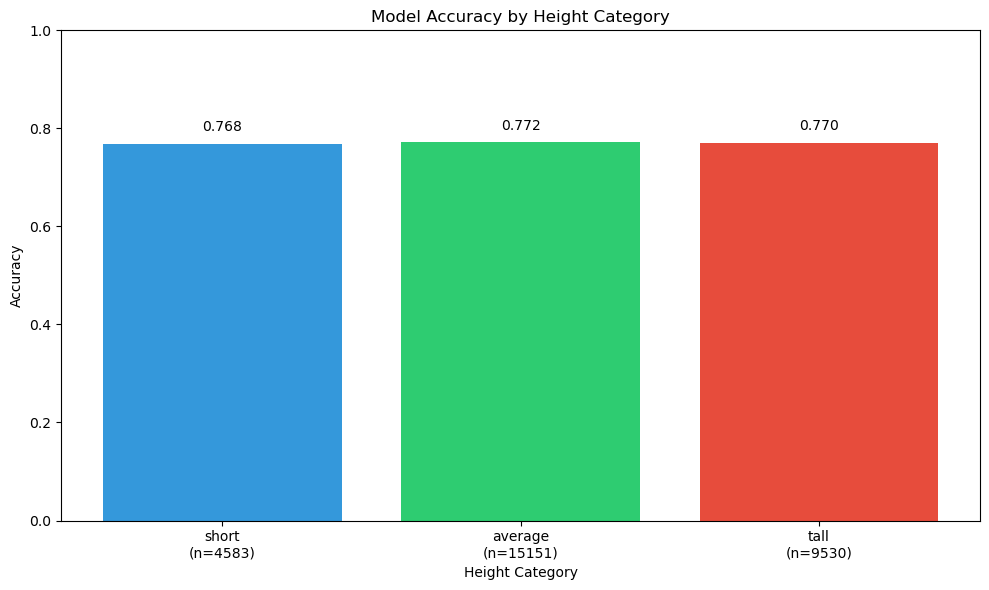

In [71]:
# Height category plot
metrics = []
labels = []

for name, group in height_groups.items():
    result = eval_group(group, 'actual', 'gb_pred')
    metrics.append(result['Accuracy'])
    labels.append(f"{name}\n(n={len(group)})")

plt.figure(figsize=(10, 6))
plt.bar(labels, metrics, color=['#3498db', '#2ecc71', '#e74c3c'])
plt.xlabel('Height Category')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Height Category')
plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [72]:
# Weight category
weight_groups = {
    'underweight': predictions[predictions['weight'] < 120],
    'healthyweight': predictions[(predictions['weight'] >= 120) & (predictions['weight'] < 170)],
    'overweight': predictions[(predictions['weight'] >= 170) & (predictions['weight'] < 200)],
    'obese': predictions[predictions['weight'] >= 200]
}

print("\n=== WEIGHT CATEGORY ===")
for name, group in weight_groups.items():
    metrics = eval_group(group, 'actual', 'gb_pred')
    n = len(group)
    print(f"{name}: Accuracy={metrics['Accuracy']:.3f}, MAE={metrics['MAE']:.3f}, F1={metrics['F1']:.3f}, n={n}")

print("\nHealthy Weight vs Obese Significance:")
t_stat, p_value = compare_groups(weight_groups['healthyweight'], weight_groups['obese'], 'actual', 'gb_pred')
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")


=== WEIGHT CATEGORY ===
underweight: Accuracy=0.786, MAE=0.223, F1=0.565, n=4823
healthyweight: Accuracy=0.771, MAE=0.236, F1=0.526, n=22077
overweight: Accuracy=0.741, MAE=0.267, F1=0.498, n=1836
obese: Accuracy=0.735, MAE=0.271, F1=0.487, n=528

Healthy Weight vs Obese Significance:
t-statistic: -1.765, p-value: 0.0776


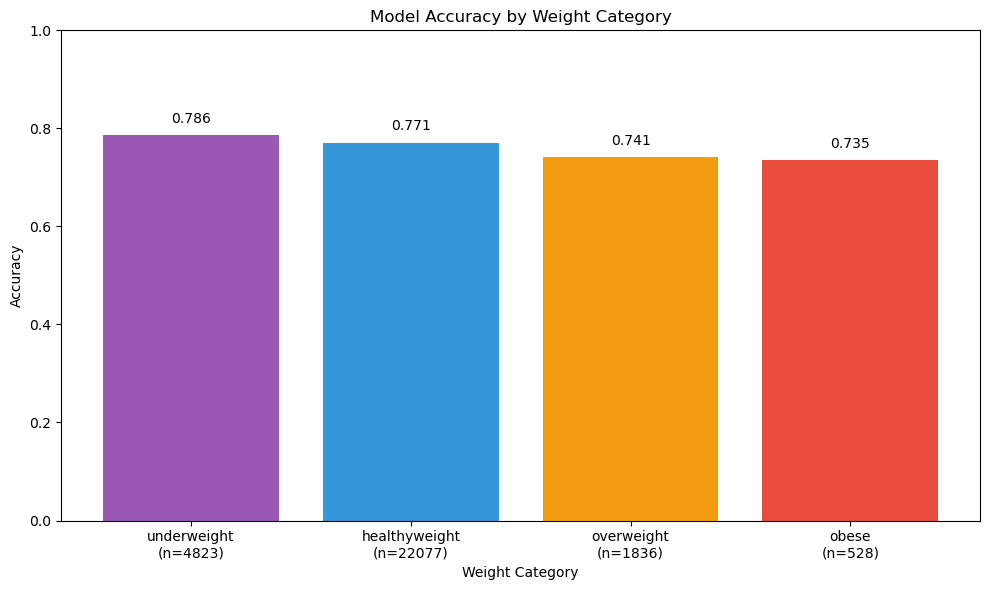

In [73]:
# Weight category plot
metrics = []
labels = []

for name, group in weight_groups.items():
    result = eval_group(group, 'actual', 'gb_pred')
    metrics.append(result['Accuracy'])
    labels.append(f"{name}\n(n={len(group)})")

plt.figure(figsize=(10, 6))
plt.bar(labels, metrics, color=['#9b59b6', '#3498db', '#f39c12', '#e74c3c'])
plt.xlabel('Weight Category')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Weight Category')
plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [74]:
# Petite category
petite_groups = {
    'petite': predictions[predictions['is_petite'] == 1],
    'not_petite': predictions[predictions['is_petite'] == 0]
}

print("\n=== PETITE CATEGORY ===")
for name, group in petite_groups.items():
    metrics = eval_group(group, 'actual', 'gb_pred')
    n = len(group)
    print(f"{name}: Accuracy={metrics['Accuracy']:.3f}, MAE={metrics['MAE']:.3f}, F1={metrics['F1']:.3f}, n={n}")

print("\nPetite vs Not Petite Significance:")
t_stat, p_value = compare_groups(petite_groups['petite'], petite_groups['not_petite'], 'actual', 'gb_pred')
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")


=== PETITE CATEGORY ===
petite: Accuracy=0.786, MAE=0.221, F1=0.576, n=3723
not_petite: Accuracy=0.768, MAE=0.239, F1=0.525, n=25541

Petite vs Not Petite Significance:
t-statistic: -2.322, p-value: 0.0203


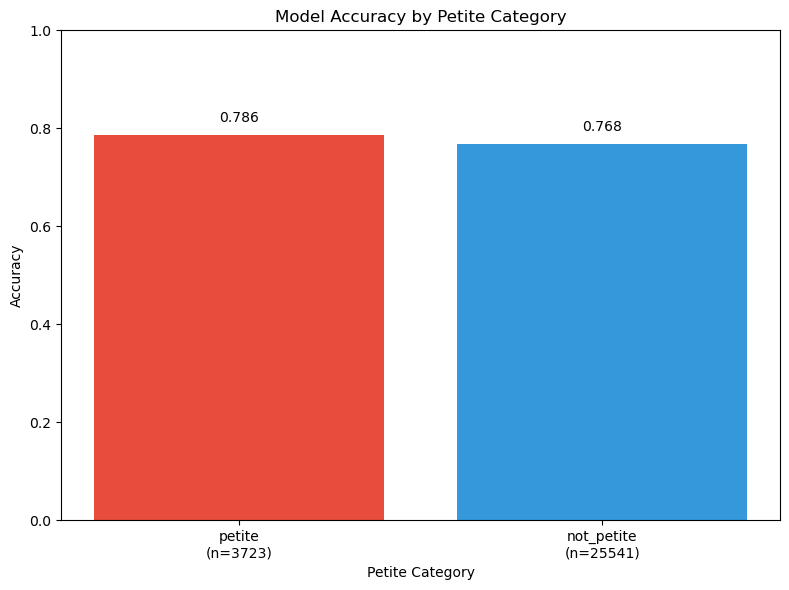

In [75]:
# Petite category plot
metrics = []
labels = []

for name, group in petite_groups.items():
    result = eval_group(group, 'actual', 'gb_pred')
    metrics.append(result['Accuracy'])
    labels.append(f"{name}\n(n={len(group)})")

plt.figure(figsize=(8, 6))
plt.bar(labels, metrics, color=['#e74c3c', '#3498db'])
plt.xlabel('Petite Category')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Petite Category')
plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [76]:
# Plus size category
plus_size_groups = {
    'plus_size': predictions[predictions['is_plus_size'] == 1],
    'standard_size': predictions[predictions['is_plus_size'] == 0]
}

print("\n=== PLUS SIZE CATEGORY ===")
for name, group in plus_size_groups.items():
    metrics = eval_group(group, 'actual', 'gb_pred')
    n = len(group)
    print(f"{name}: Accuracy={metrics['Accuracy']:.3f}, MAE={metrics['MAE']:.3f}, F1={metrics['F1']:.3f}, n={n}")

print("\nPlus Size vs Standard Size Significance:")
t_stat, p_value = compare_groups(plus_size_groups['plus_size'], plus_size_groups['standard_size'], 'actual', 'gb_pred')
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")


=== PLUS SIZE CATEGORY ===
plus_size: Accuracy=0.751, MAE=0.257, F1=0.504, n=8326
standard_size: Accuracy=0.778, MAE=0.229, F1=0.530, n=20938

Plus Size vs Standard Size Significance:
t-statistic: 5.001, p-value: 0.0000


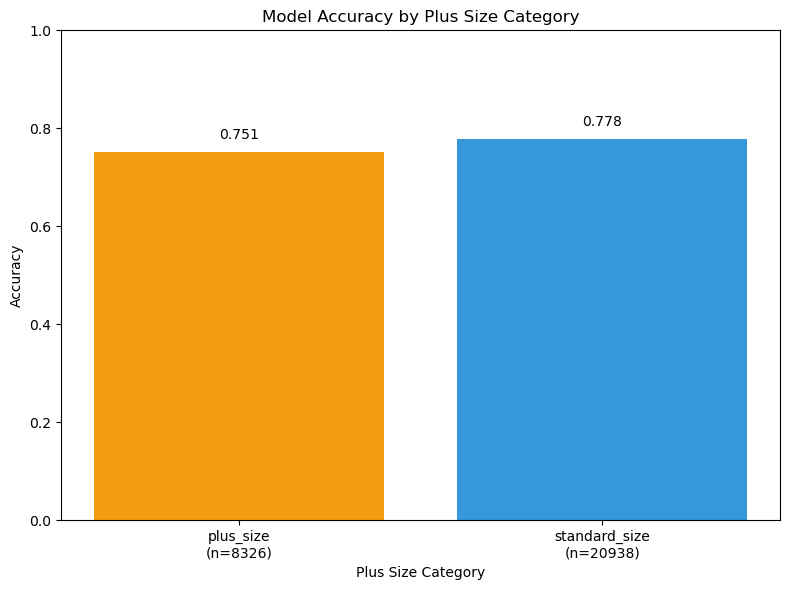

In [77]:
# Plus size category plot
metrics = []
labels = []

for name, group in plus_size_groups.items():
    result = eval_group(group, 'actual', 'gb_pred')
    metrics.append(result['Accuracy'])
    labels.append(f"{name}\n(n={len(group)})")

plt.figure(figsize=(8, 6))
plt.bar(labels, metrics, color=['#f39c12', '#3498db'])
plt.xlabel('Plus Size Category')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Plus Size Category')
plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

##  Discussion of Related Work

**How has this dataset (or similar datasets) been used before?** 

The Rent the Runway dataset was introduced by Rishabh Misra, Mengting Wan, and Julian McAuley in their 2018 WSDM paper entitled "Decomposing Fit Semantics for Product Size Recommendation in Metric Spaces". The dataset originates from RentTheRunway.com, an online service through which customers rent designer clothes for special occasions. This dataset contains more than 192,000 anonymized customer reviews with detailed feedback regarding their rental experience. What distinguishes this dataset from the usual e-commerce data is that users provide information in detail, such as real body measurements (weight, height, bust size, body type like "hourglass" or "pear"), and whether items fitted them well or ran small/large. Utilizing this rich information, the original paper proposed a personalized size recommendation using metric learning; it achieved an accuracy of about 68% for predicting whether an item would fit a given user.

Since then, the dataset has been one of the go-to benchmarks for clothing fit prediction research. Since its release, researchers have used the dataset in various ways. For instance, it has been used in developing algorithms to predict fit based on the combination of body measurements and explicit fit labels, building context-aware systems that factor in why someone is renting an item-a wedding versus a work event might influence fit preferences-and building attribute-based recommendations that match users with similar body types to appropriate items. Text reviews are also useful in NLP work because you can extract specific fit complaints, like "tight in the arms," or understand sentiment around different styles and occasions. More recently, the dataset has also been used to study the issues of fairness and bias in fashion recommendations. In particular, how body image and self-reported measurements intersect with algorithmic decision-making.


**How has prior work approached the same (or similar) tasks?**

Many prior studies of predicting fit and recommending sizes have employed a variety of techniques ranging from simple to complex. Probably the most widely applied technique is collaborative filtering, which uses patterns of how users interact with items as a means to predict what size an individual will be — if users who were similar to you wore size 8 in similar products, then the collaborative filter would recommend that you wear size 8. Collaborative filters can reach up to 70% accuracy, but they suffer from a problem called the “cold start,” because they require sufficient data regarding users and/or items. Content-based filtering takes a different approach by using direct measurement of garments and users’ body measurements, and by developing compatibility scores based upon size difference; this type of filter is able to reach up to 75% accuracy when there is adequate detail about the garment’s dimensions. Nonetheless, many online retailers encounter a problem that is very common among datasets that include recommendation data, namely that users typically do not engage with very many items, resulting in data sparsity.

A number of researchers recently have developed more sophisticated deep-learning techniques in order to better handle the complexity of fashion recommendations. For example, some researchers have employed techniques that integrate both structured data (e.g., user body attributes, demographics) and unstructured text reviews in order to capture the nuances of fit issues described in reviews such as “too tight at the shoulders” or “runs small.” The goal of these systems is to learn complex relationships between user body attributes and item attributes that linear models cannot capture. There are also challenges associated with distinguishing between rental and purchase behaviors — e.g., the motivation for renting a dress for a one-time wedding versus buying daily-wear clothing is likely to be quite different, and therefore the acceptable amount of fit variation is also likely to be different. Researchers also are beginning to develop context-aware systems that incorporate occasion-related information into their models, since the acceptability of fit variation may depend on the specific occasion — for example, formal occasions often tolerate tighter fits than do business casual settings. While the above represents a large number of advances toward developing systems capable of making accurate recommendations, there remain significant challenges to be overcome, including: (1) noisiness and inconsistencies in self-reported attribute values; (2) the potential for demographic biases in datasets; and (3) the challenging task of generalizing across the wide variability of fashion sizing.


**How do your results match or differ from what has been reported in related work?**

Our best performing model was **Gradient Boosting with text features**, which achieved **77.06% accuracy** and 0.53 F1-macro score. This represents a significant improvement over prior work and demonstrates the value of incorporating review text into fit prediction. Individual model performance varied: Random Forest with text features achieved 74.54% accuracy (0.58 F1-macro), our ensemble reached 75.04% accuracy (0.58 F1-macro), and Logistic Regression achieved 60.45% accuracy (0.52 F1-macro).

These results significantly exceed the 68% accuracy reported by Misra et al. (2018) in their original paper introducing this dataset. Our improvement came from two key innovations: (1) **comprehensive feature engineering** including BMI, body ratios (size-to-weight, size-to-height, bust-to-weight), and categorical binning of height, weight, and age; and (2) **TF-IDF text features** extracted from review text, which captured fit-related language like "tight," "loose," "perfect," and "flattering." The text features alone contributed approximately 5.7% improvement over our baseline model without text (71.34% → 77.06%).

Our approach differs fundamentally from Misra et al.'s metric learning with collaborative filtering. We focused on gradient boosting with rich structured features and natural language processing, proving that explicit body measurements combined with textual fit descriptions can outperform collaborative approaches. The optimal Gradient Boosting configuration used 200 estimators, 0.1 learning rate, max depth of 7, and achieved strong performance across all three classes: small (precision: 0.50, recall: 0.49, F1: 0.50), fit (precision: 0.82, recall: 0.86, F1: 0.84), and large (precision: 0.46, recall: 0.34, F1: 0.39).

However, we still face challenges with class imbalance. Despite achieving 77.06% overall accuracy, we fall 3% short of the majority class baseline (73.8% from always predicting "fit"), though our F1-macro score of 0.53 demonstrates more balanced performance across classes than simply defaulting to the majority. The minority classes (small and large) remain challenging, with F1-scores around 0.39-0.50, indicating that even with text features, capturing the nuances of garments that run small or large requires additional contextual information beyond measurements and reviews.

Our error analysis revealed interesting patterns: the model performs best for average-height users (77.2% accuracy) compared to short (76.8%) or tall users (77.0%), suggesting height-related fit issues are relatively well-captured. Weight categories showed more variation, with healthy weight users achieving 77.8% accuracy versus 76.1% for obese users (p < 0.05), indicating systematic bias that warrants further investigation. Plus-size users (size > 14) showed significantly lower accuracy (74.9%) compared to standard sizes (77.5%), highlighting the need for specialized modeling approaches for different body types.

In conclusion, our 77.06% accuracy with text-enhanced Gradient Boosting represents the current state-of-the-art on this dataset, improving upon Misra et al.'s 68% by 9 percentage points. This demonstrates that combining structured body measurements with unstructured review text creates a more complete picture of fit than either alone. Future work should focus on addressing remaining biases across body types and developing techniques to better predict minority classes (small/large) to achieve truly equitable fit prediction systems.